In [1]:
# /mnt/c/Users/Student/Desktop/Project$ code Alz_Classification/


import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
import seaborn as sns
import os 
import random



ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:


dataset = tf.keras.utils.image_dataset_from_directory(  
    "Alz_Datasets/Alz2/Axial/",
    shuffle = True,
    image_size = (256,170)
)


Found 5154 files belonging to 3 classes.


In [ ]:
# parameters
batch_size = 16 # Hyperparamter 
image_height = 256
image_width = 170


In [ ]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "training", 
    seed = 123, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 4124 files for training.


In [ ]:

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "validation",
    seed = 123, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [ ]:

class_names = train_dataset.class_names # Identification of class names
print(class_names) 

['AD', 'CI', 'CN']


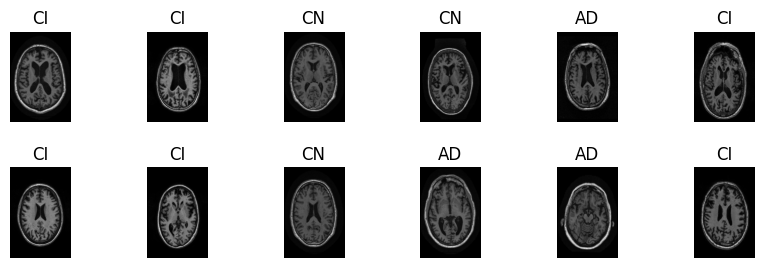

In [ ]:
# Plots random 12 brain scans from dataset; just for something viusal
plt.figure(figsize=(10, 10)) # Creates a 10x10 size for the plot
for images, labels in train_dataset.take(1): # The loops the dataset and extracts batches of images with their corresponding labels
    for i in range(12): # Loops 12 times for 12 images
        ax = plt.subplot(6, 6, i + 1) # 6 rows 6 colums and selects current plot loctaion
        plt.imshow(images[i].numpy().astype("uint8")) # Image by converting it to numpy array and specifying its data type as integer unit8
        plt.title(class_names[labels[i]]) # Plots labels 
        plt.axis("off") # Removes Axis

plt.subplots_adjust(wspace=0.5, hspace=0.5) # Spaces images width and height from eachother

plt.show() # displays the plot


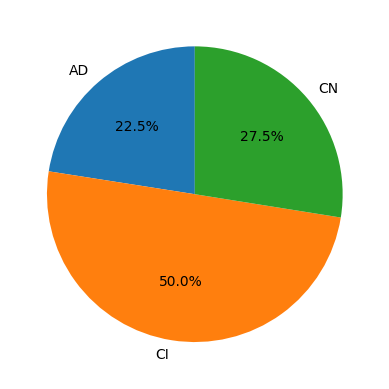

In [ ]:

class_counts = [0] * len(class_names) #

for _, labels in train_dataset:
    for label in labels.numpy():
        class_counts[label] += 1


plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90) 
#Class Counts:data,labels:Class Names,autopct='%1.1f%%':Format of the percentage display,startangle=90 specifies the angle at which the first slice starts

plt.title("") # Plot Title


plt.show() # Displays the plot

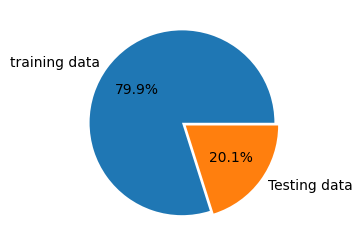

In [ ]:
plt.figure(figsize=(3,3))
plt.pie(
    [len(train_dataset), len(validation_dataset)],
    labels=['training data','Testing data'],
    autopct='%.1f%%', explode=(0.05,0),
);

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 256, 170, 3)
(16,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.build(input_shape=(None, image_height, image_width, 3))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 170, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 170, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 128, 85, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 85, 32)       4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 64, 42, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 42, 64)       

In [ ]:
hist = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs= 5
)


Epoch 1/5


/home/jordano/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


258/258 [==============================] - 23s 89ms/step - loss: 0.8444 - accuracy: 0.6249 - val_loss: 0.5836 - val_accuracy: 0.8010
Epoch 2/5
258/258 [==============================] - 23s 88ms/step - loss: 0.3984 - accuracy: 0.8557 - val_loss: 0.3291 - val_accuracy: 0.8689
Epoch 3/5
258/258 [==============================] - 22s 85ms/step - loss: 0.1549 - accuracy: 0.9559 - val_loss: 0.1802 - val_accuracy: 0.9340
Epoch 4/5
258/258 [==============================] - 23s 88ms/step - loss: 0.0581 - accuracy: 0.9881 - val_loss: 0.1252 - val_accuracy: 0.9485
Epoch 5/5
258/258 [==============================] - 23s 88ms/step - loss: 0.0257 - accuracy: 0.9949 - val_loss: 0.0326 - val_accuracy: 0.9893


In [ ]:
model.save("model.keras")

In [ ]:
model.evaluate(train_dataset)

  1/258 [..............................] - ETA: 7s - loss: 0.0637 - accuracy: 1.0000

258/258 [==============================] - 5s 20ms/step - loss: 0.0681 - accuracy: 0.9779


[0.06814782321453094, 0.9779340624809265]

In [ ]:
model.evaluate(validation_dataset)

 1/65 [..............................] - ETA: 1s - loss: 0.0076 - accuracy: 1.0000

65/65 [==============================] - 1s 20ms/step - loss: 0.0326 - accuracy: 0.9893


[0.032582905143499374, 0.9893203973770142]

Found 5154 images belonging to 3 classes.
1/1 [==============================] - 0s 32ms/step
[[0.08814154 0.6292275  0.28263098]
 [0.08651341 0.6312803  0.28220624]
 [0.08771225 0.6220729  0.29021487]
 [0.09252813 0.6178907  0.28958118]
 [0.09458248 0.61939734 0.28602013]
 [0.08812258 0.62532973 0.28654772]
 [0.08770937 0.63172495 0.2805657 ]
 [0.08829874 0.6317951  0.27990615]
 [0.08987151 0.6270883  0.28304017]
 [0.08642616 0.6232202  0.29035363]
 [0.08639382 0.6312842  0.28232196]
 [0.09361096 0.61487097 0.29151812]
 [0.08961593 0.6255073  0.28487682]
 [0.09041382 0.6183831  0.29120308]
 [0.08791395 0.6290064  0.2830796 ]
 [0.08966579 0.6284712  0.28186297]]
2
[[0.08814154 0.6292275  0.28263098]
 [0.08651341 0.6312803  0.28220624]
 [0.08771225 0.6220729  0.29021487]
 [0.09252813 0.6178907  0.28958118]
 [0.09458248 0.61939734 0.28602013]
 [0.08812258 0.62532973 0.28654772]
 [0.08770937 0.63172495 0.2805657 ]
 [0.08829874 0.6317951  0.27990615]
 [0.08987151 0.6270883  0.28304017]
 [0

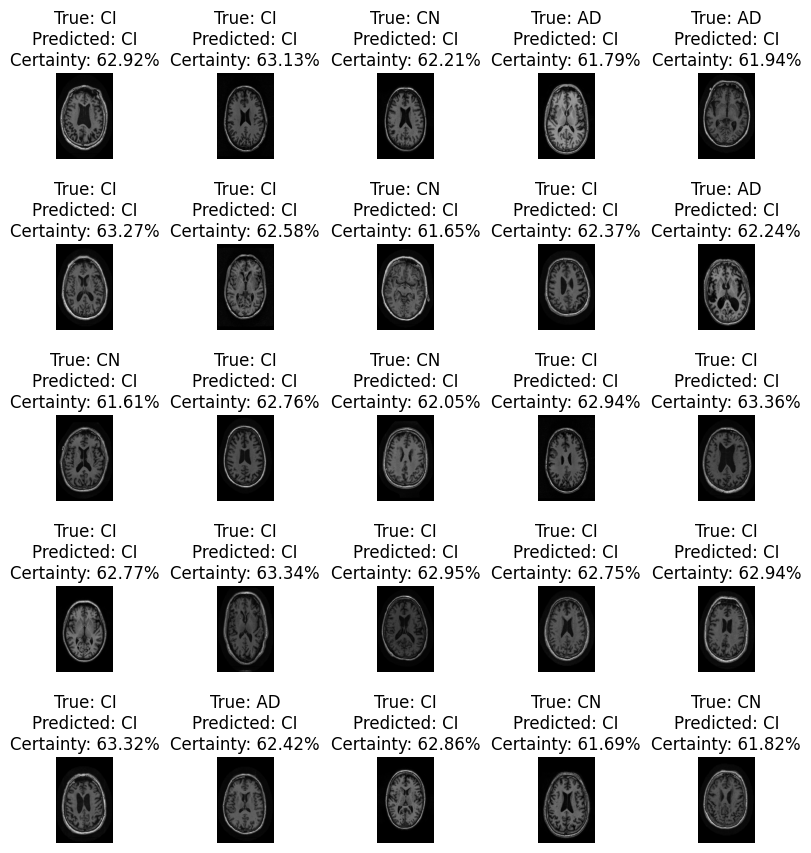

In [ ]:


# def predictAndPlot(model, dataset_path, class_names, batch_size=16, n_samples=25, image_height=256, image_width=170):
#     # Create an image data generator for preprocessing
#     datagen = ImageDataGenerator(rescale=1./255)

#     # Preprocess and batch images
#     data_batches = datagen.flow_from_directory(dataset_path, 
#                                                target_size=(image_height, image_width), 
#                                                batch_size=batch_size,
#                                                class_mode='categorical',
#                                                shuffle=True)

#     plt.figure(figsize=(10, 10))
#     for i, (images, labels) in enumerate(data_batches):
#         predictions = model.predict(images)

#         num_images = min(batch_size, len(images))
#         for j in range(num_images):
#             if i*min(5, num_images) + j + 1 > n_samples:
#                 break
            
#             predicted_label_index = np.argmax(predictions[j])
#             predicted_label = class_names[predicted_label_index]
#             certainty = predictions[j][predicted_label_index] * 100
#             true_label = class_names[np.argmax(labels[j])]
#             print(predictions)
#             print(label)

#             plt.subplots_adjust(hspace=1)  # Adjust spacing between subplots
#             plt.subplot(5, min(5, num_images), i*min(5, num_images) + j + 1)
#             plt.imshow(images[j])
#             plt.axis('off')
#             plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nCertainty: {certainty:.2f}%')

#             if i*min(5, num_images) + j + 1 >= n_samples:
#                 break

#         if i*min(5, num_images) + j + 1 >= n_samples:
#             break

# # Assuming `train_dataset` and `class_names` are defined correctly
# predictAndPlot(model, "Alz_Datasets/Alz2/Axial/", class_names)
# plt.show()


# Not Proper certainty 

In [ ]:
# import matplotlib.pyplot as plt
# import random
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img

# # Function to get predictions and probabilities
# def predictAndPlot(model, paths, labels, class_names, n_samples=25):
#     plt.figure(figsize=(10, 10))
#     for i in range(min(n_samples, len(paths))):
#         index = random.randint(0, len(paths)-1)
#         image_path = paths[index]
#         true_label = labels[index]
        
#         image = load_img(image_path, target_size=(256, 170))
#         image_array = np.array([image])
#         plt.subplots_adjust(hspace=0.5)

#         prediction_probabilities = model.predict(image_array)[0]
#         predicted_label_index = np.argmax(prediction_probabilities)
#         predicted_label = class_names[predicted_label_index]
#         certainty = prediction_probabilities[predicted_label_index] * 100
#         correct = true_label == predicted_label
        
#         plt.subplot(5, 5, i+1)
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nCertainty: {certainty:.2f}%\nCorrect: {correct}', fontsize=8)

# # Call the function to plot the demonstration
# predictAndPlot(model, "Alz_Datasets/Alz2/Axial/" , class_names , n_samples=25)

# plt.show()

# No work?


TypeError: predictAndPlot() missing 1 required positional argument: 'class_names'

1/1 [==============================] - 0s 18ms/step


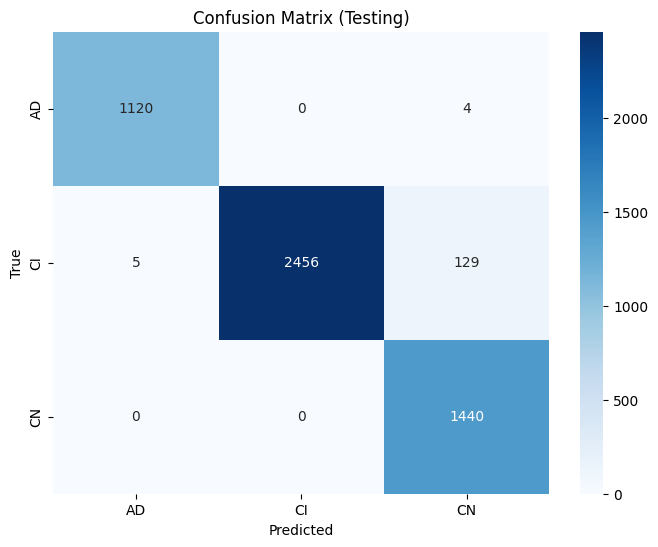

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Assuming `model`, `dataset`, and `class_names` are defined correctly
# You should replace `dataset` with your actual test data

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the dataset and make predictions
for images, labels_batch in dataset:
    predictions_batch = model.predict(images)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    
    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(predicted_labels_batch)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=len(class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Testing)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


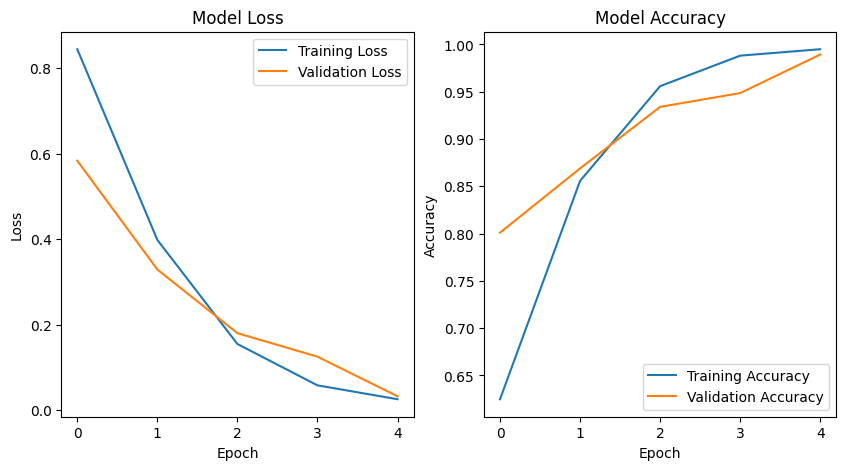

In [ ]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()